<a href="https://colab.research.google.com/github/ashok-arora/ML-Zoomcamp/blob/main/mid_term_project/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Hit Predictor

**Dataset**: https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset

**Link to repository**: https://github.com/ashok-arora/ML-Zoomcamp/mid_term_project

Note: The README.md inside the repository containes the problem statement and the detailed description of the approach.  


## This notebook has been organized in the form of:

code snippet

---

followed by the inference from the output of the code snippet. 

## Importing the necessary libraries

In [ ]:
import glob
import os

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn


from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load Data


In [ ]:
# all_files = glob.glob("./*.csv")
# df = pd.concat((pd.read_csv(f) for f in all_files))
# df.to_csv('./combined_dataset.csv', index=False)

df = pd.read_csv('./combined_dataset.csv')

In [ ]:
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Misty Roses,Astrud Gilberto,spotify:track:50RBM1j1Dw7WYmsGsWg9Tm,0.527,0.316,1,-15.769,1,0.0310,0.693000,0.00699,0.1680,0.543,116.211,158840,4,53.89523,6,0
1,Never Ever,All Saints,spotify:track:5FTz9qQ94PyUHETyAyfYZN,0.738,0.541,1,-5.485,1,0.0311,0.559000,0.00000,0.0492,0.309,134.187,387573,4,32.16853,16,1
2,Soul Sermon,Gregg Karukas,spotify:track:6m24oe3lk1UMxq9zq4iPFi,0.736,0.419,0,-10.662,1,0.0300,0.693000,0.49500,0.0809,0.265,93.982,237267,4,42.05369,9,0
3,Clarinet Marmalade - Live,Alton Purnell,spotify:track:5FOXuiLI6knVtgMUjWKj6x,0.565,0.594,5,-13.086,1,0.0646,0.655000,0.92600,0.6750,0.763,114.219,375933,4,80.99693,10,0
4,До смерті і довше - Drum & Base and Rock Remix,Skryabin,spotify:track:6CxyIPTqSPvAPXfrIZczs4,0.513,0.760,4,-10.077,1,0.0355,0.000017,0.00339,0.1530,0.961,153.166,430653,4,25.57331,20,0


In [ ]:
df.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target'],
      dtype='object')

The column names contain no spaces and are all lowercase and hence correctly formatted. 

Next, dropping the non-useful columns: track, artist and uri.  





In [ ]:
df = df.drop(['track', 'artist', 'uri'], axis=1)

In [ ]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'target'],
      dtype='object')

In [ ]:
print(f'The dataset consists of {len(df)} rows.')

The dataset consists of 41106 rows.


In [ ]:
df.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
chorus_hit          float64
sections              int64
target                int64
dtype: object

Since the dtype is either float64 or int64, the dataset consists of **numerical attributes only**. This information will be helpful in selecting a criterion for removing non-useful features.

## Exploratory Data Analysis (EDA)

In [ ]:
df.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

**No missing values** were found for any of the columns in the dataset and hence there is no need to fill them with mean or median.

In [ ]:
df.target.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

The ratio of values in each class is **equal**, this highlights that there is **no class imbalance** and thus the classifier will not be biased towards a particular class. 

---

Incase of class imbalance, Synthetic Minority Oversampling Technique (SMOTE) is used to fix it.  

In [ ]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599793,8.000000,0.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,0.500000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,1.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000


From the description above, it can be inferred that attributes `danceability, energy, mode, speechiness, acousticness, instrumentalness, liveliness and valence` have been normalized between `[0, 1]`.

In [ ]:
#going to focus on the spotify features when comparing the hits and flops
all_songs_hits = df.drop('target', axis=1).loc[df['target'] == 1]
all_songs_flops = df.drop('target', axis=1).loc[df['target'] == 0]

hits_means = pd.DataFrame(all_songs_hits.describe().loc['mean'])
flops_means = pd.DataFrame(all_songs_flops.describe().loc['mean'])
means_joined = pd.concat([hits_means,flops_means, (hits_means-flops_means)], axis = 1)
means_joined.columns = ['hit_mean', 'flop_mean', 'difference']
means_joined

,hit_mean,flop_mean,difference
danceability,0.601237,0.478153,0.123085
energy,0.624296,0.534794,0.089501
key,5.248528,5.178660,0.069868
loudness,-8.702237,-11.740813,3.038576
mode,0.730064,0.656644,0.073420
speechiness,0.069444,0.076477,-0.007033
acousticness,0.280814,0.447581,-0.166767
instrumentalness,0.030687,0.278145,-0.247458
liveness,0.192637,0.210432,-0.017796
valence,0.609578,0.475302,0.134276


In [ ]:
means_joined.sort_values('difference', ascending=False)

,hit_mean,flop_mean,difference
loudness,-8.702237,-11.740813,3.038576
tempo,120.288280,118.388219,1.900061
valence,0.609578,0.475302,0.134276
danceability,0.601237,0.478153,0.123085
energy,0.624296,0.534794,0.089501
time_signature,3.938063,3.849316,0.088746
mode,0.730064,0.656644,0.073420
key,5.248528,5.178660,0.069868
speechiness,0.069444,0.076477,-0.007033
liveness,0.192637,0.210432,-0.017796


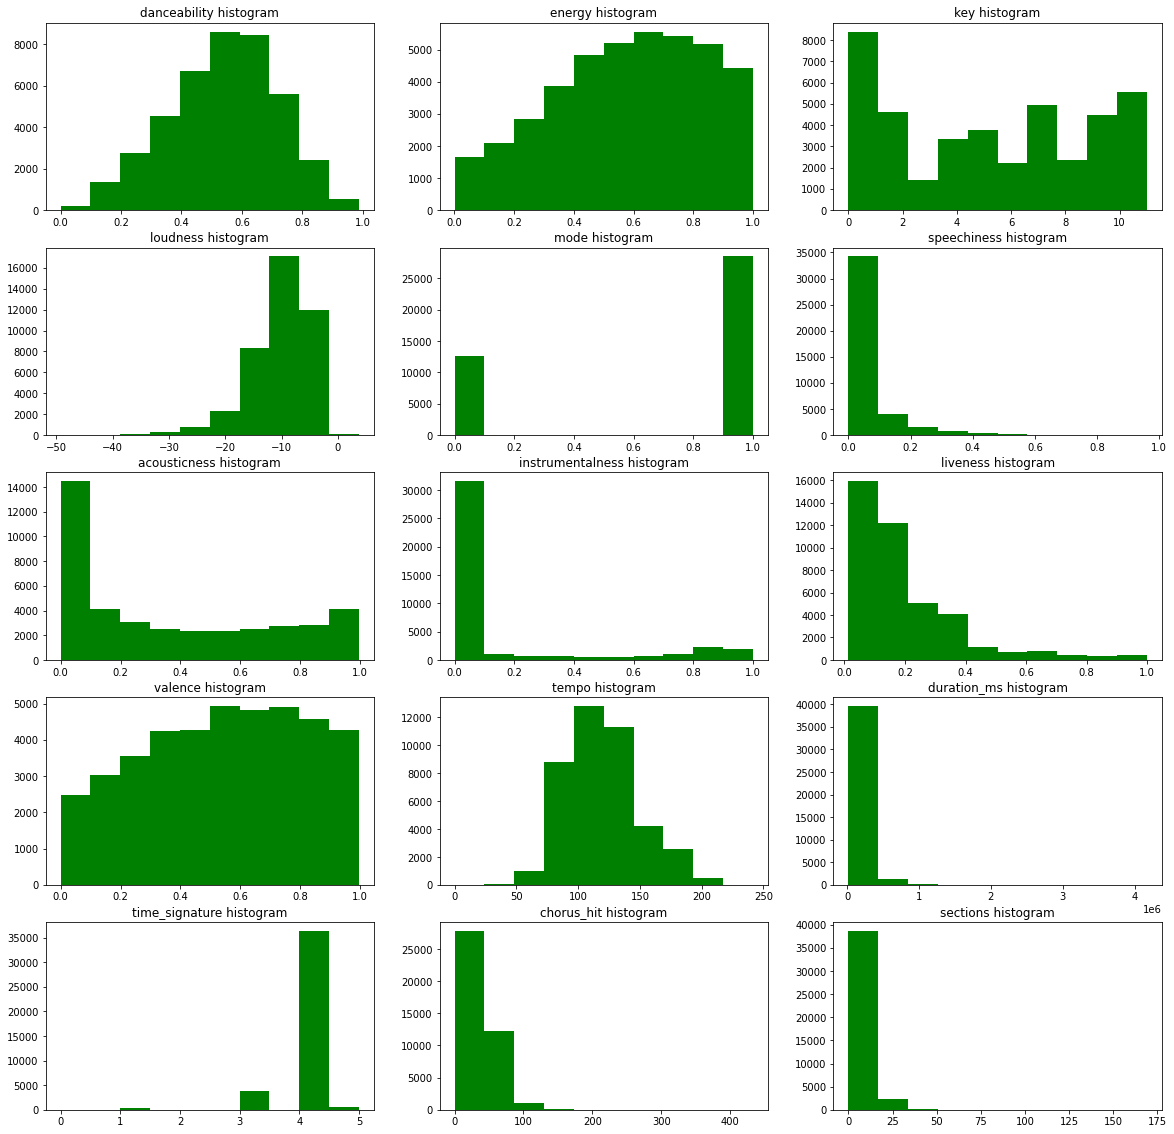

In [ ]:
#create histograpms of all the variables to see distributions
fig, ax = plt.subplots(5,3, figsize=(20,20))

def hist_plot(row=0, column=0, variable=None, binsnum=10, color='g'):
    ax[row, column].hist(df[variable], bins = binsnum, color = color)
    ax[row, column].set_title(variable + ' histogram')

idx = 0
for i in range(0, 5):
  for j in range(0, 3):
      hist_plot(i, j, df.columns[idx])
      idx += 1 

From the above cells, it can be concluded that hit songs have high values of `loudness, tempo, valence, danceability, energy, time_signature, mode` and low values of `speechiness, liveness, acousticness, instrumentalness, sections, chorus_hit, duration_ms`.

In [ ]:
pearson_corr = df.drop('target', axis=1).corr(method='pearson')
pearson_corr

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
danceability,1.000000,0.206128,0.015433,0.274160,-0.032743,0.156452,-0.261252,-0.301915,-0.115251,0.553858,-0.066541,-0.063030,0.191664,-0.036277,-0.058615
energy,0.206128,1.000000,0.022523,0.772628,-0.033780,0.122430,-0.715088,-0.208153,0.157779,0.341427,0.224018,0.011830,0.196072,0.009620,-0.040233
key,0.015433,0.022523,1.000000,0.008438,-0.140455,0.026515,-0.024178,-0.013101,0.000668,0.007742,0.001154,0.015493,0.004757,0.010264,0.006784
loudness,0.274160,0.772628,0.008438,1.000000,0.000509,0.069241,-0.566548,-0.374301,0.086708,0.271775,0.169453,-0.049890,0.165520,-0.013401,-0.080065
mode,-0.032743,-0.033780,-0.140455,0.000509,1.000000,-0.059636,0.049961,-0.075992,0.008886,0.035636,0.027053,-0.074828,-0.009483,-0.022594,-0.057095
speechiness,0.156452,0.122430,0.026515,0.069241,-0.059636,1.000000,-0.083948,-0.084092,0.131488,0.001528,0.036854,0.007631,0.021085,0.012972,-0.008636
acousticness,-0.261252,-0.715088,-0.024178,-0.566548,0.049961,-0.083948,1.000000,0.204137,-0.030765,-0.195331,-0.179700,-0.070271,-0.188139,-0.012409,-0.016824
instrumentalness,-0.301915,-0.208153,-0.013101,-0.374301,-0.075992,-0.084092,0.204137,1.000000,-0.050582,-0.287047,-0.053618,0.106551,-0.077980,0.048654,0.081188
liveness,-0.115251,0.157779,0.000668,0.086708,0.008886,0.131488,-0.030765,-0.050582,1.000000,0.000784,0.024861,0.005336,0.004773,0.037981,-0.011742
valence,0.553858,0.341427,0.007742,0.271775,0.035636,0.001528,-0.195331,-0.287047,0.000784,1.000000,0.107901,-0.172166,0.155669,-0.059120,-0.133527


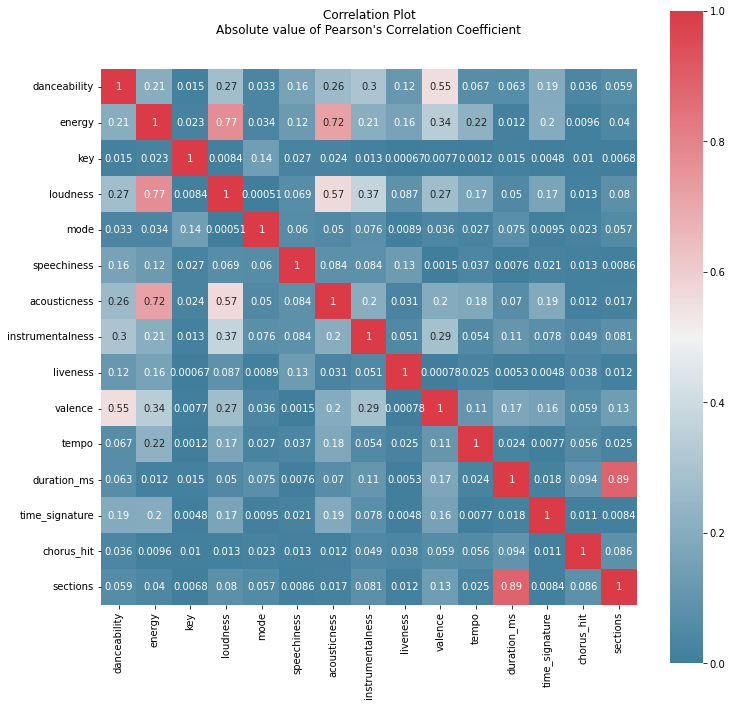

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.title("Correlation Plot\nAbsolute value of Pearson's Correlation Coefficient\n\n")
sns.heatmap(pearson_corr.abs(),
            cmap=sns.diverging_palette(230, 10, as_cmap=True),
            square=True,
            vmin=0,
            vmax=1,
            ax=ax,
            annot=True)
plt.show()

In [ ]:
spearman_corr = df.drop('target', axis=1).corr(method='spearman')
spearman_corr

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
danceability,1.000000,0.164115,0.015135,0.192920,-0.039545,0.126314,-0.177026,-0.258663,-0.151263,0.534031,-0.044877,0.039293,0.204459,-0.023284,0.030663
energy,0.164115,1.000000,0.022282,0.755831,-0.037773,0.313679,-0.704296,-0.112258,0.125210,0.302188,0.224814,0.117404,0.204824,-0.001290,0.034705
key,0.015135,0.022282,1.000000,0.011473,-0.138723,0.034355,-0.025846,-0.003685,-0.003244,0.005408,0.001514,0.019078,0.007465,0.008298,0.005600
loudness,0.192920,0.755831,0.011473,1.000000,-0.016053,0.175412,-0.545557,-0.326982,0.082311,0.173122,0.151807,0.057817,0.152944,-0.010751,0.000460
mode,-0.039545,-0.037773,-0.138723,-0.016053,1.000000,-0.105583,0.055872,-0.079649,0.016884,0.033830,0.026574,-0.096990,-0.013926,-0.015232,-0.063743
speechiness,0.126314,0.313679,0.034355,0.175412,-0.105583,1.000000,-0.207493,-0.024476,0.087085,0.041495,0.097644,0.035815,0.063520,0.007550,-0.007361
acousticness,-0.177026,-0.704296,-0.025846,-0.545557,0.055872,-0.207493,1.000000,0.060174,-0.017131,-0.114566,-0.190844,-0.224878,-0.187073,-0.009121,-0.119316
instrumentalness,-0.258663,-0.112258,-0.003685,-0.326982,-0.079649,-0.024476,0.060174,1.000000,-0.052351,-0.229456,-0.033247,0.122798,-0.061281,0.044166,0.082300
liveness,-0.151263,0.125210,-0.003244,0.082311,0.016884,0.087085,-0.017131,-0.052351,1.000000,-0.029925,0.020468,-0.068181,-0.002913,0.018235,-0.064969
valence,0.534031,0.302188,0.005408,0.173122,0.033830,0.041495,-0.114566,-0.229456,-0.029925,1.000000,0.110336,-0.171493,0.165699,-0.044105,-0.103174


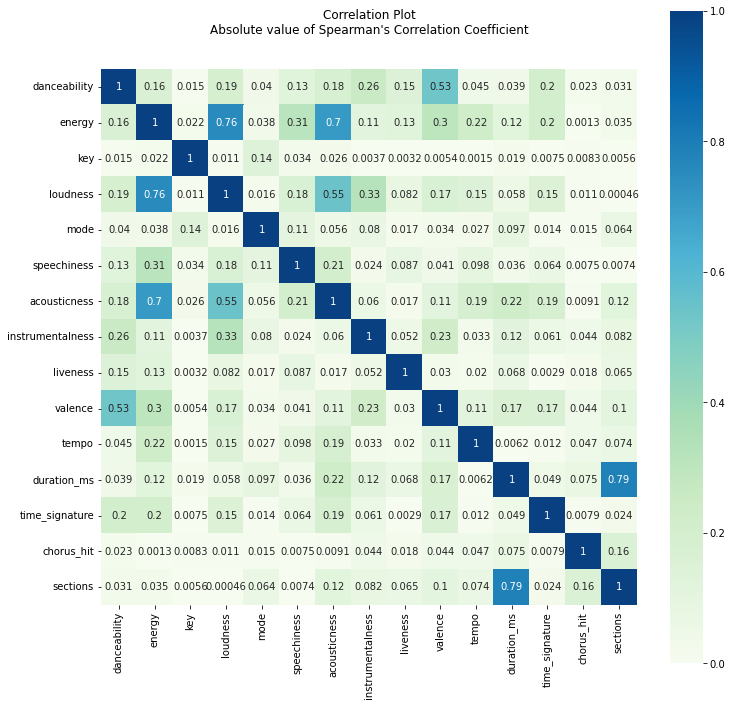

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.title("Correlation Plot\nAbsolute value of Spearman's Correlation Coefficient\n\n")
sns.heatmap(spearman_corr.abs(),
            cmap='GnBu',
            square=True,
            vmin=0,
            vmax=1,
            ax=ax,
            annot=True)
plt.show()

In [ ]:
df = df.drop(['duration_ms'], axis=1)

In [ ]:
from sklearn.feature_selection import f_classif
anova_f_values = f_classif(df.drop(['target'], axis=1), df['target'])[0]

linear_corr = pd.Series(anova_f_values, index=df.drop(['target'], axis=1).columns)
linear_corr.sort_values(ascending=False)

instrumentalness    8191.354832
danceability        5593.567971
loudness            3662.603077
valence             2767.155200
acousticness        2648.497971
energy              1331.603763
time_signature       457.200615
mode                 262.192995
duration_ms          225.216243
sections             148.494372
liveness             109.074262
chorus_hit            88.718788
speechiness           68.656857
tempo                 43.861277
key                    4.014785
dtype: float64

Since the correlation values between any two variables is not greater than 90%, none of the attributes were removed.

## Model Training & Tuning


### Splitting entire dataset into train/val/test ratio of 80/20/20 %

In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)
print(len(df), len(df_full_train), len(df_train), len(df_val), len(df_test))

41106 32884 24663 8221 8222


In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

In [ ]:
del df_train['target']
del df_val['target']
del df_test['target']

In [ ]:
df_val

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
0,Protector of the Common Folk,Howard Shore,spotify:track:3wlVdDCUCO1SS3xND0pBBc,0.1960,0.0765,0,-22.721,0,0.0380,0.904000,0.805000,0.1110,0.0381,111.672,215065,4,47.23415,11
1,Mega Force,707,spotify:track:3LQwO6kRKpAUxHunIJHDAh,0.4190,0.8750,9,-6.584,1,0.0732,0.012400,0.001150,0.2110,0.7260,140.783,241333,4,32.75766,11
2,Peau d'âne arrive à la ferme,Michel Legrand,spotify:track:2Q8gJke42fYWvZPPzGaFCH,0.3790,0.3120,7,-14.960,1,0.0320,0.971000,0.782000,0.0911,0.1360,75.594,96467,1,62.04693,5
3,We'll Sing In The Sunshine,Gale Garnett,spotify:track:3WYYzUlLrl4NVNeoKd7MnG,0.5360,0.3510,11,-8.026,1,0.0266,0.762000,0.000000,0.2200,0.5320,106.730,179120,4,20.30345,10
4,Looking at You,The Damned,spotify:track:55oYn88qoKKWZCI0W0xoVO,0.2710,0.9270,2,-8.030,1,0.1180,0.000178,0.361000,0.1130,0.3950,125.258,307060,4,30.19480,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8216,Shangri-La,Vic Dana,spotify:track:5uPKJXCJse6seJX3DegLDN,0.2550,0.2830,8,-9.941,1,0.0294,0.848000,0.000003,0.0822,0.1420,85.574,126347,3,41.17920,6
8217,Binaural Beta Sinus Drone II,The Entrainment,spotify:track:0lkzynfIVpyaY80ARPIFwy,0.0733,0.0120,2,-28.885,1,0.0567,0.996000,0.990000,0.0864,0.0307,176.654,212000,3,121.99132,12
8218,Talk Talk,The Music Machine,spotify:track:3J9VPVRnoqyF0keO1nReTz,0.6840,0.8640,1,-6.838,1,0.0461,0.038400,0.000233,0.1070,0.8410,107.028,118133,4,20.68042,7
8219,L'homme et son chien,Vladimir Cosma,spotify:track:7M3Y6833GRH45yL4OH7Msk,0.3640,0.0929,2,-19.964,0,0.0328,0.964000,0.838000,0.1220,0.2020,113.024,149427,4,24.80795,9


### Using a dict vectorizer 

(Note: the dataset consists of only Numerical variables, using a dict vectorizer will not have any effect, this is to show that the shape does not change.)

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [ ]:
train_dicts = df_train.to_dict(orient='records')

In [ ]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [ ]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [ ]:
df_val.shape

(8221, 15)

In [ ]:
X_val.shape

(8221, 15)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(solver='lbfgs', random_state=11)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.4828437283025032

In [ ]:
y_pred = model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.4900156738527594

The untuned LR model has an accuracy of 48.28% on the validation dataset.

In [ ]:
param_grid = {
              'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
              'C' : np.logspace(0, 5, 10),
              'solver' : ['liblinear', 'lbfgs', 'newton-cg']
              }

In [ ]:
grid_search = GridSearchCV(LogisticRegression(random_state=11), param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 439 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 861 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  9.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=11, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg']

In [ ]:
final_model = grid_search.best_estimator_
final_model

LogisticRegression(C=3.5938136638046276, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=11, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = final_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8084125763648298

In [ ]:
y_pred = final_model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.8030103843105169

Using a grid search with 10 fold cross validation helped in finding the right hyperparamaters to boost the accuracy to 80.84%.

### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text

In [ ]:
dt = DecisionTreeClassifier(random_state=11)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=11, splitter='best')

In [ ]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6997740056812296

In [ ]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9999997303756941

The untuned decision tree model has an accuracy of 69.97% on the validation dataset.

In [ ]:
param_grid = {
              'criterion' :['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth' : [4, 5, 6, 7, 8, 9],
              'min_samples_leaf': [1, 5, 10, 15, 20, 50],
              'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
             }

In [ ]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=11), param_grid=param_grid, verbose=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1416 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6216 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  2.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=11,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                     

In [ ]:
final_model = grid_search.best_estimator_
final_model

DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=11, splitter='best')

In [ ]:
y_pred = final_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8190606201052075

In [ ]:
y_pred = final_model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.8198789094883174

Using a grid search with 10 fold cross validation helped in finding the right hyperparamaters to boost the accuracy to 81.90%.

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=11)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8694196480100009

In [ ]:
y_pred = rf.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9999970209802301

The untuned random forest has an accuracy of 86.94% on the validation dataset.

In [ ]:
param_grid = {
              'n_estimators' :[100, 110, 120, 130, 140, 150],
              'max_depth' : [5, 10, 15],
              'min_samples_leaf': [1, 3, 5, 10],
             }

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=11), param_grid=param_grid, cv=2, verbose=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.7min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=11,
                                  

In [ ]:
final_model = grid_search.best_estimator_
final_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=130,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [ ]:
final_model.fit(X_train, y_train)
y_pred = final_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8664044469620693

In [ ]:
y_pred = final_model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9438656662789469

Using a grid search did not boost the accuracy, this could be because the param_grid supplied to the search wasn't good enough so I'll try to find the best values for the following parameters manually: 
  
  * n_estimators
  * max_depth
  * min_samples_leaf

For n_estimators, I chose [10, 130] as the initial range.

In [ ]:
scores = []

for n in range(10, 131, 10):
  rf = RandomForestClassifier(n_estimators=n, random_state=11, n_jobs=-1)
  rf.fit(X_train, y_train)

  y_pred = rf.predict_proba(X_val)[:, 1]
  score = roc_auc_score(y_val, y_pred)
  scores.append((n, score))

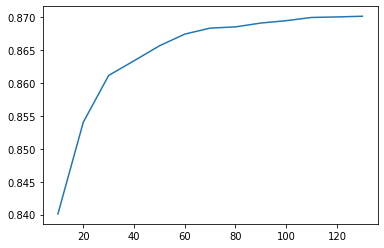

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)

but the accuracy kept increasing, so I increased the range to [10, 1000] to find a stagnation in accuracy value.

In [ ]:
scores = []

for n in range(10, 1001, 100):
  rf = RandomForestClassifier(n_estimators=n, random_state=11, n_jobs=-1)
  rf.fit(X_train, y_train)

  y_pred = rf.predict_proba(X_val)[:, 1]
  score = roc_auc_score(y_val, y_pred)
  scores.append((n, score))

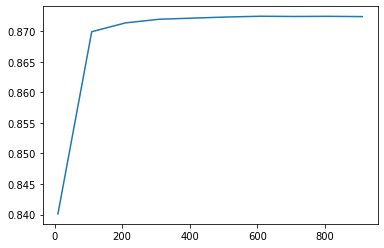

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)

The accuracy seems to stagnates around n=500 at about 87.2%. 

In [ ]:
scores = []

for d in range(1, 150, 15):
    for n in range(10, 501, 100):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=11, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [ ]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

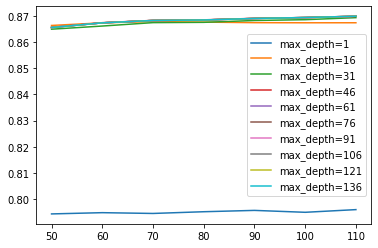

In [ ]:
for d in range(1, 150, 15):
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [ ]:
for d in range(1, 150, 15):
  print('{} {}'.format(d, df_scores[df_scores.max_depth == d].auc.max()))

1 0.7959516947502194
16 0.8678736468013044
31 0.8693738631473586
46 0.8698642376716783
61 0.8699089570817966
76 0.8699089570817966
91 0.8699089570817966
106 0.8699089570817966
121 0.8699089570817966
136 0.8699089570817966


The best value of max_depth is 61. 

The aim is to maximize accuracy but also minimize max_depth value since then it will consume less time and computational power.

In [ ]:
max_depth = 61

In [ ]:
scores = []

for s in range(1, 51, 10): # [1, 3, 5, 10, 50]:
    for n in range(10, 501, 100):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=11, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

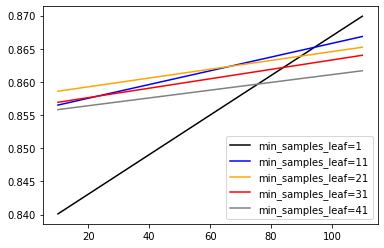

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = range(1, 51, 10) # [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

The value of min_samples_leaf = 1 gives the best accuracy on the validation dataset.

Hence, the final parameter values are:
 * n_estimators=500,
 * max_depth=61,
 * min_samples_leaf=1

In [ ]:
min_samples_leaf = 1

In [ ]:
rf = RandomForestClassifier(n_estimators=500,
                            max_depth=61,
                            min_samples_leaf=1,
                            random_state=11, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=61, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8723245747216654

In [ ]:
y_pred = rf.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.999997527347829

Tuning the hyperparamaters boosted the accuracy of random forest from 86.94% to 87.23% on the validation dataset.

### XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 60,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-auc:0.95715	val-auc:0.812824
[5]	train-auc:0.998246	val-auc:0.847703
[10]	train-auc:0.999844	val-auc:0.855626
[15]	train-auc:0.999997	val-auc:0.859398
[20]	train-auc:0.999999	val-auc:0.861318
[25]	train-auc:1	val-auc:0.86263
[30]	train-auc:1	val-auc:0.863969
[35]	train-auc:1	val-auc:0.864549
[40]	train-auc:1	val-auc:0.865306
[45]	train-auc:1	val-auc:0.865413
[50]	train-auc:1	val-auc:0.865806
[55]	train-auc:1	val-auc:0.865856
[60]	train-auc:1	val-auc:0.86614
[65]	train-auc:1	val-auc:0.866648
[70]	train-auc:1	val-auc:0.866519
[75]	train-auc:1	val-auc:0.86646
[80]	train-auc:1	val-auc:0.866526
[85]	train-auc:1	val-auc:0.866888
[90]	train-auc:1	val-auc:0.866955
[95]	train-auc:1	val-auc:0.867287
[100]	train-auc:1	val-auc:0.867376
[105]	train-auc:1	val-auc:0.867545
[110]	train-auc:1	val-auc:0.867743
[115]	train-auc:1	val-auc:0.867774
[120]	train-auc:1	val-auc:0.867703
[125]	train-auc:1	val-auc:0.867693
[130]	train-auc:1	val-auc:0.867812
[135]	train-auc:1	val-auc:0.868037
[140]	train

In [ ]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8678414168624435

In [ ]:
y_pred = model.predict(dtrain)
roc_auc_score(y_train, y_pred)

0.9999997303756941

The untuned XG Boost model has an accuracy of 86.78% on the validation dataset. 

Using grid search on XG Boost was very time-consuming so I am going to manually tune the following hyperparameters by plotting them and picking the best:

* eta
* max_depth
* min_child_weight

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
etas = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.08, 
    'max_depth': 100,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
etas[key] = parse_xgb_output(output)
key

'eta=0.08'

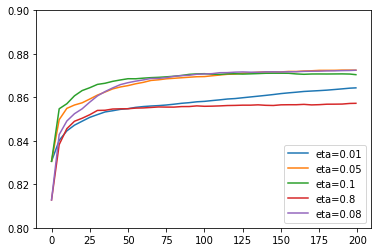

In [ ]:
for eta, df_score in etas.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.ylim(0.8, 0.9)
plt.legend()

From the plot, it is clear that eta=0.08 gives the best accuracy. 

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.08, 
    'max_depth': 200,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=200'

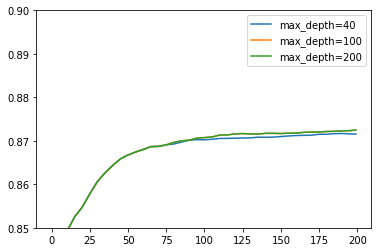

In [ ]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.85, 0.9)
plt.legend()

max_depth=100 and max_depth=200 have overlapping plots, since lower value of max_depth saves time and computational power, max_depth=100 is selected.

In [ ]:
weights = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.08, 
    'max_depth': 100,
    'min_child_weight': 4,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
weights[key] = parse_xgb_output(output)
key

'min_child_weight=4'

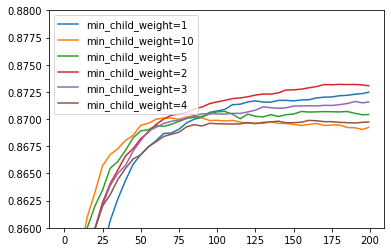

In [ ]:
for min_child_weight, df_score in weights.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.86, 0.88)
plt.legend()

From the plot, it is clear the min_child_weight=2 gives the best accuracy on validation dataset.

In [ ]:
xgb_params = {
    'eta': 0.08, 
    'max_depth': 100,
    'min_child_weight': 2,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=20,
                  evals=watchlist)

[0]	train-auc:0.935605	val-auc:0.814424
[20]	train-auc:0.995004	val-auc:0.859923
[40]	train-auc:0.999436	val-auc:0.866614
[60]	train-auc:0.999971	val-auc:0.869505
[80]	train-auc:0.999998	val-auc:0.870606
[100]	train-auc:0.999999	val-auc:0.871581
[120]	train-auc:1	val-auc:0.872051
[140]	train-auc:1	val-auc:0.872413
[160]	train-auc:1	val-auc:0.87288
[180]	train-auc:1	val-auc:0.873194
[199]	train-auc:1	val-auc:0.873063


In [ ]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8730628149374076

Tuning the hyperparameters manually boosted the accuracy from 86.78% to 87.30% on the validation dataset.

## Selecting the best model

### Logistic Regression

In [ ]:
lr = LogisticRegression(C=3.5938136638046276, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=11, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
lr.fit(X_train, y_train)

LogisticRegression(C=3.5938136638046276, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=11, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lr.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8084125763648298

### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=11, splitter='best')
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=11, splitter='best')

In [ ]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8190606201052075

### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=500,
                            max_depth=61,
                            min_samples_leaf=1,
                            random_state=11, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=61, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8723245747216654

### XG Boost


In [ ]:
xgb_params = {
    'eta': 0.08, 
    'max_depth': 100,
    'min_child_weight': 2,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200) # ,evals=watchlist)

In [ ]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8730628149374076

The best performing model is XG Boost with an accuracy of 87.30% on the validation dataset, it will be exported to a Pickle file to be used with the Flask application. 

## Store best model as Pickle file

In [ ]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.target.values
del df_full_train['target']

In [ ]:
dv = DictVectorizer(sparse=False)

dicts_full_train = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [ ]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

In [ ]:
xgb_params = {
    'eta': 0.08, 
    'max_depth': 100,
    'min_child_weight': 2,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=200)

In [ ]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8644872551344663

The accuracy of the full_train dataset is 86.44% which is close to the validation dataset accuracy. 

In [ ]:
import pickle

In [ ]:
output_file = 'final_model_xgb.bin'

f_out = open(output_file, 'wb') 
pickle.dump((dv, model), f_out)
f_out.close()

In [ ]:
!ls -lh *.bin

-rw-r--r-- 1 root root 11M Oct 30 12:20 final_model_xgb.bin


In [ ]:
with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, model), f_out)

## Load best model using

In [ ]:
input_file = 'final_model_xgb.bin'

In [ ]:
with open(input_file, 'rb') as f_in: 
    dv, model = pickle.load(f_in)

In [ ]:
song = df_full_train.to_dict(orient='records')[0]

In [ ]:
X = dv.transform([song])
dX = xgb.DMatrix(X, feature_names=dv.get_feature_names())

In [ ]:
y_pred = model.predict(dX)

In [ ]:
print('input:', song)
print('output:', y_pred)

input: {'danceability': 0.369, 'energy': 0.94, 'key': 9, 'loudness': -3.6719999999999997, 'mode': 1, 'speechiness': 0.086, 'acousticness': 0.00048499999999999997, 'instrumentalness': 0.0006389999999999999, 'liveness': 0.14, 'valence': 0.517, 'tempo': 110.021, 'duration_ms': 148867, 'time_signature': 4, 'chorus_hit': 31.05358, 'sections': 7}
output: [0.00519087]
